<a href="https://colab.research.google.com/github/GarlandZhang/hairy_gan/blob/master/hairy_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os

import pandas as pd
import os
import shutil
if not os.path.exists('kaggle.json'):
  shutil.copy('/content/drive/My Drive/hairy_gan/kaggle.json', 'kaggle.json')
  # !pip install -q kaggle
  # files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !kaggle datasets download -d jessicali9530/celeba-dataset --force
  !unzip celeba-dataset.zip
  !mv img_align_celeba celeba-dataset
  !mv list_eval_partition.csv celeba-dataset/list_eval_partition.csv
  !mv list_landmarks_align_celeba.csv celeba-dataset/list_landmarks_align_celeba.csv
  !mv list_attr_celeba.csv celeba-dataset/list_attr_celeba.csv
  !mv list_bbox_celeba.csv celeba-dataset/list_bbox_celeba.csv

  !mkdir celeba-dataset/train
  !mkdir celeba-dataset/validation
  !mkdir celeba-dataset/test

  partitions_df = pd.read_csv('celeba-dataset/list_eval_partition.csv') # 0 => train, 1 => validation, 2 => test
  for i, set_name in enumerate(['train', 'validation', 'test']):
    set_ids_df = partitions_df.loc[partitions_df['partition'] == i]['image_id']
    set_ids = set_ids_df.tolist()
    for id in set_ids:
      shutil.copy(os.path.join('celeba-dataset/img_align_celeba', id), os.path.join('celeba-dataset', f'{set_name}', id))

  !git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && pip install git+https://www.github.com/keras-team/keras-contrib.git \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install

  !pip install scipy==1.1.0

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197910.jpg  
  inflating: img_align_celeba/img_align_celeba/197911.jpg  
  inflating: img_align_celeba/img_align_celeba/197912.jpg  
  inflating: img_align_celeba/img_align_celeba/197913.jpg  
  inflating: img_align_celeba/img_align_celeba/197914.jpg  
  inflating: img_align_celeba/img_align_celeba/197915.jpg  
  inflating: img_align_celeba/img_align_celeba/197916.jpg  
  inflating: img_align_celeba/img_align_celeba/197917.jpg  
  inflating: img_align_celeba/img_align_celeba/197918.jpg  
  inflating: img_align_celeba/img_align_celeba/197919.jpg  
  inflating: img_align_celeba/img_align_celeba/197920.jpg  
  inflating: img_align_celeba/img_align_celeba/197921.jpg  
  inflating: img_align_celeba/img_align_celeba/197922.jpg  
  inflating: img_align_celeba/img_align_celeba/197923.jpg  
  inflating: img_align_celeba/img_align_celeba/197924.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [2]:
from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, Embedding
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam
from keras.models import load_model, save_model

import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.python.keras.backend import set_session, clear_session
# from tensorflow.python.keras.models import load_model
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.enable_eager_execution()

from tqdm import tqdm

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
!rm -r celeba-dataset/train_filter
!mkdir celeba-dataset/train_filter
# extract images of particular class for training
num_images_each = 25
feature = 'Bald'
complete_df = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
for img_id in complete_df.loc[complete_df[feature] == 1][:num_images_each].filter(['image_id']).to_numpy():
  img_id = img_id[0]
  shutil.copy(f'celeba-dataset/train/{img_id}', f'celeba-dataset/train_filter/{img_id}')

for img_id in complete_df.loc[complete_df[feature] == -1][:num_images_each].filter(['image_id']).to_numpy():
  img_id = img_id[0]
  shutil.copy(f'celeba-dataset/train/{img_id}', f'celeba-dataset/train_filter/{img_id}')

rm: cannot remove 'celeba-dataset/train_filter': No such file or directory


In [4]:
class DataLoader():
    def __init__(self, dataset_name, img_res):
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.complete_df = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
        self.features = ['Bald', 'Bangs', 'Eyeglasses', 'Mustache', 'No_Beard', 'Sideburns', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat']
        self.num_attrs = len(self.features)

    def load_data(self, dataset_type, batch_size=1, is_testing=False):
        data_type = dataset_type
        path = glob('%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        attribs = []
        
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

            # get attributes

            img_attribs = [(val + 1) // 2 for val in self.complete_df.loc[self.complete_df['image_id'] == os.path.basename(img_path)].filter(items=self.features).to_numpy()[0]]

            attribs.append(img_attribs)

        imgs = np.array(imgs)/127.5 - 1.
        attribs = np.array(attribs)

        return imgs, attribs

    def load_batch(self, batch_size=1, is_testing=False, is_filter=False):
        if is_filter:
          data_type = 'train_filter'
        elif is_testing:
          data_type = 'test'
        else:
          data_type = 'train'
        path = glob('%s/%s/*' % (self.dataset_name, data_type))

        self.n_batches = int(len(path) / batch_size)
        total_samples = self.n_batches * batch_size

        path = np.random.choice(path, total_samples, replace=False)

        i = 0
        while i < self.n_batches - 1:
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs = []
            attribs = []
            for img_path in batch:
                img = self.imread(img_path)

                img = scipy.misc.imresize(img, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img = np.fliplr(img)

                imgs.append(img)

                # get attributes

                img_attribs = np.array([(val + 1) // 2 for val in self.complete_df.loc[self.complete_df['image_id'] == os.path.basename(img_path)].filter(items=self.features).to_numpy()[0]])

                attribs.append(img_attribs)

            imgs = np.array(imgs)/127.5 - 1.
            attribs = np.array(attribs)

            i += 1
            if i == self.n_batches - 1:
              # reset
              path = glob('%s/%s/*' % (self.dataset_name, data_type))
              path = np.random.choice(path, total_samples, replace=False)
              i = 0

            yield imgs, attribs

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [44]:
def build_encoder(img_shape, num_filters=64, kernel_size=4, strides=2):
  def build_conv(x, num_filters, kernel_size, strides):
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

  img = Input(shape=img_shape)
  x = build_conv(img, num_filters, kernel_size, strides)
  x = build_conv(x, num_filters * 2, kernel_size, strides)
  x = build_conv(x, num_filters * 4, kernel_size, strides)
  x = build_conv(x, num_filters * 8, kernel_size, strides)
  x = build_conv(x, num_filters * 16, kernel_size, strides)
  # x.name = 'encoder_output'

  model = Model(img, x, name='encoder')

  model.summary()

  return model

def build_embedding(img, label, input_shape, attr_size):
  label_embedding = Embedding(2, np.prod(input_shape), input_length=attr_size)(label)
  # style_embedding = Embedding(2, np.prod(input_shape), input_length=attr_size)(style)
  # label_style_embedding = Add()([label_embedding, style_embedding])
  # label_style_embedding = Reshape(input_shape[:-1] + (attr_size * input_shape[-1], ))(label_style_embedding)
  # emb_img = Concatenate(axis=-1)([img, label_style_embedding])
  label_embedding = Reshape(input_shape[:-1] + (attr_size * input_shape[-1], ))(label_embedding)
  emb_img = Concatenate(axis=-1)([img, label_embedding])
  return emb_img

def build_decoder(latent_space_shape, attr_size, num_filters=64, kernel_size=4, strides=1):
  def build_deconv(x, num_filters, kernel_size, strides):
    x = UpSampling2D(size=2)(x)
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

  img = Input(shape=latent_space_shape)
  label = Input(shape=(attr_size, ), dtype='int32')

  emb_img = build_embedding(img, label, latent_space_shape, attr_size)

  x = build_deconv(emb_img, num_filters * 16, kernel_size=kernel_size, strides=strides)
  x = build_deconv(x, num_filters * 8, kernel_size=kernel_size, strides=strides)
  x = build_deconv(x, num_filters * 4, kernel_size=kernel_size, strides=strides)
  x = build_deconv(x, num_filters * 2, kernel_size=kernel_size, strides=strides)
  x = UpSampling2D(size=2)(x)
  x = Conv2D(3, kernel_size=kernel_size, strides=strides, padding='same', activation='tanh')(x)
  # x.name = 'decoder_output'

  model = Model([img, label], x, name='decoder')

  model.summary()

  return model

def build_convnet(img, num_filters=64, kernel_size=4, strides=2):
  def build_conv(x, num_filters, kernel_size, strides):
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU()(x)
    return x
  
  x = build_conv(img, num_filters, kernel_size, strides)
  x = build_conv(x, num_filters * 2, kernel_size, strides)
  x = build_conv(x, num_filters * 4, kernel_size, strides)
  x = build_conv(x, num_filters * 8, kernel_size, strides)
  x = build_conv(x, num_filters * 16, kernel_size, strides)
  x = Flatten()(x)
  x = Dense(1024)(x)
  x = InstanceNormalization()(x)
  x = LeakyReLU()(x)

  return x

def build_discriminator(img_shape, optimizer):
  img = Input(shape=img_shape)
  x = build_convnet(img)
  output = Dense(1, activation='sigmoid', name='disc_output')(x)

  disc = Model(img, output, name='discriminator')
  disc.compile(loss='binary_crossentropy', optimizer=optimizer)

  disc.summary()

  return disc

def build_classifier(img_shape, attr_size, optimizer):
  img = Input(shape=img_shape)
  x = build_convnet(img)

  output = Dense(attr_size, activation='sigmoid', name='classif_output')(x)

  classif = Model(img, output, name='classifier')

  classif.compile(loss='binary_crossentropy', optimizer=optimizer)

  classif.summary()

  return classif

def build_combined_generator(img_shape, attr_size, genc, gdec, classifier, discriminator, optimizer):
  classifier.trainable = False

  x_a = Input(shape=img_shape) # original image
  a = Input(shape=(attr_size, )) # original attr
  b = Input(shape=(attr_size, )) # requested attr
  
  z = genc(x_a) # latent space representation of original image
  x_b = gdec([z, b]) # image with requested attr

  b_hat = classifier(x_b) # guess attributes
  valid = discriminator(x_b) # guess real or fake

  x_a_hat = gdec([z, a]) # reconstr

  combined = Model(
      inputs=[x_a, a, b],
      outputs=[b_hat, valid, x_a_hat],
      name='combined'
  )

  combined.compile(loss=['binary_crossentropy', 'binary_crossentropy', 'mae'], loss_weights=[10, 1, 100], optimizer=optimizer)

  combined.summary()

  return combined

In [6]:
def shuffle(elems):
  new_elems = elems.copy()
  np.random.shuffle(new_elems)
  return new_elems

def create_random_attrs(attrs):
  # new_attrs = np.ones((attrs.shape))
  # count = attrs.shape[0]
  # attr_size = attrs[0].size
  
  new_attrs = np.random.randint(0, 2, size=attrs.shape)
  # for r in range(count):
  #   for c in range(attr_size):
  #     if attrs[r, c] == 1 and new_attrs[r, c] == 0:
  #       new_attrs[r, c] = 1
  
  return new_attrs

In [54]:
def train_classifier_step(gen_batch, classifier):
  imgs, attrs = gen_batch

  x_a = imgs
  a = attrs

  classif_history = classifier.fit(x_a, a)

  return classif_history

def train_discriminator_step(batch_size, gen_batch, enc, dec, discriminator):
  imgs, attrs, new_attrs = gen_batch

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  x_a = imgs
  a = attrs
  b = new_attrs

  z = enc.predict(x_a)
  x_b = dec.predict([z, b])

  disc_real_history = discriminator.fit(x_a, real)
  disc_fake_history = discriminator.fit(x_b, fake)

  return disc_real_history, disc_fake_history

def train_encdec_step(batch_size, gen_batch, combined):
  imgs, attrs, new_attrs = gen_batch

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  x_a = imgs
  a = attrs
  b = new_attrs

  g_real_history = combined.fit([x_a, a, b], [b, fake, x_a])

  return g_real_history

In [48]:
class HairyGan(): # based on AttGan
  def __init__(self, flags={}):

    self.img_rows = 128
    self.img_cols = 128
    self.img_channels = 3

    self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
    
    patch = int(self.img_rows / 2**4)
    self.disc_out = (patch, patch, 1) # output shape of discriminator

    self.dl = DataLoader(dataset_name='celeba-dataset', img_res=(self.img_rows, self.img_cols))

    self.optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

    self.flags = flags

    if os.path.exists(os.path.join(project_path, 'enc.h5')):
      print('Loading encoder from file')
      self.enc = load_model(os.path.join(project_path, 'enc.h5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.enc = build_encoder(self.img_shape)
    
    if os.path.exists(os.path.join(project_path, 'dec.h5')):
      print('Loading decoder from file')
      self.dec = load_model(os.path.join(project_path, 'dec.h5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.dec = build_decoder((4, 4, 1024), self.dl.num_attrs)

    self.disc = build_discriminator(self.img_shape, self.optimizer)
    
    if os.path.exists(os.path.join(project_path, 'disc.weights')):
      print('Loading disc from file')
      self.disc.load_weights(os.path.join(project_path, 'disc.weights'))


    self.classif = build_classifier(self.img_shape, self.dl.num_attrs, self.optimizer)
    
    if os.path.exists(os.path.join(project_path, 'classif.weights')):
      print('Loading classif from file')
      self.classif.load_weights(os.path.join(project_path, 'classif.weights'))

    self.combined = build_combined_generator(self.img_shape, self.dl.num_attrs, self.enc, self.dec, self.classif, self.disc, self.optimizer)   

    self.metrics = {}

  def pretrain_classifier(self, num_epochs, batch_size, visualize_interval):
    # set up data loader
    batch_gen = self.dl.load_batch(batch_size=batch_size, is_filter=self.flags['filter_on'])
    for i, elem in enumerate(batch_gen):
      break
  
    num_batches = self.dl.n_batches
    steps_per_epoch = num_batches

    count = 0

    for epoch in range(num_epochs):
      for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {num_epochs}', total=steps_per_epoch):
        gen_batch = next(batch_gen)

        classif_history = train_classifier_step(gen_batch, self.classif)
        classif_history.history['classif_loss'] = classif_history.history.pop('loss')

        self.metrics = add_metrics(self.metrics, [classif_history])

        if (count + 1) % visualize_interval == 0:
          try:
            self.sample_images(epoch, step, is_filter=self.flags['filter_on'])
            
            # save model
            self.classif.save_weights('classif.weights')
            shutil.copy('classif.weights', os.path.join(project_path, 'classif.weights'))

            # visualize loss/accuracy
            visualize_metrics(self.metrics)
          except Exception as e:
            print(e)
        
        count += 1

  def train(self, num_epochs, batch_size, visualize_interval):
    # set up data loader
    batch_gen = self.dl.load_batch(batch_size=batch_size, is_filter=self.flags['filter_on'])
    for i, elem in enumerate(batch_gen):
      break
  
    num_batches = self.dl.n_batches
    steps_per_epoch = num_batches

    count = 0

    for epoch in range(num_epochs):
      for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {num_epochs}', total=steps_per_epoch):
        imgs, attrs = next(batch_gen)
        new_attrs = create_random_attrs(attrs)
        gen_batch = (imgs, attrs, new_attrs)

        disc_real_history, disc_fake_history = train_discriminator_step(batch_size, gen_batch, self.enc, self.dec, self.disc)
        g_real_history = train_encdec_step(batch_size, gen_batch, self.combined)

        disc_real_history.history['disc_real_loss'] = disc_real_history.history.pop('loss')
        disc_fake_history.history['disc_fake_loss'] = disc_fake_history.history.pop('loss')
        g_real_history.history['g_real_loss'] = g_real_history.history.pop('loss')

        self.metrics = add_metrics(self.metrics, [disc_real_history, disc_fake_history, g_real_history])

        if (count + 1) % visualize_interval == 0:
          try:
            self.sample_images(epoch, step, is_filter=self.flags['filter_on'])
            
            # save models
            save_model(self.enc, 'enc.h5')
            shutil.copy('enc.h5', os.path.join(project_path, 'enc.h5'))

            save_model(self.dec, 'dec.h5')
            shutil.copy('dec.h5', os.path.join(project_path, 'dec.h5'))

            self.disc.save_weights('disc.weights')
            shutil.copy('disc.weights', os.path.join(project_path, 'disc.weights'))

            self.combined.save_weights('combined.weights')
            shutil.copy('combined.weights', os.path.join(project_path, 'combined.weights'))

            # visualize loss/accuracy
            visualize_metrics(self.metrics)
          except Exception as e:
            print(e)
        
        count += 1

  def sample_images(self, epoch, batch_i, is_filter=False):
    print(f'Epoch: {epoch} with batch: {batch_i}')
    rows, cols = 2, 3

    imgs, attrs = self.dl.load_data('test' if not is_filter else 'train_filter', batch_size=2, is_testing=True)

    new_attrs = create_random_attrs(attrs)

    encodings = self.enc.predict(imgs)

    reconstrs = self.dec.predict([encodings, attrs])

    new_imgs = self.dec.predict([encodings, new_attrs])
    # combined.predict([imgs, attrs, new_attrs]) 

    gen_imgs = np.array([imgs[0], new_imgs[0], reconstrs[0], imgs[1], new_imgs[1], reconstrs[1]])

    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axes = plt.subplots(rows, cols)

    count = 0

    for i in range(rows):
      for j in range(cols):
        axes[i, j].imshow(gen_imgs[count])
        axes[i, j].set_title(titles[j])
        axes[i, j].axis('off')
        count += 1

    plt.show()
    

In [9]:
def add_metrics(metrics, histories):
  for history in histories:
    for k, v in history.history.items():
      if metrics.get(k) is None:
        metrics[k] = v
      else:
        metrics[k].append(v[0]) # array of 1 elem => elem
  return metrics

In [10]:
def visualize_metrics(metrics):
  num_plots = len(metrics.keys())

  fig, axes = plt.subplots(num_plots)

  for pl, (title, values) in enumerate(metrics.items()):
    axes[pl].plot(values)
    axes[pl].set_title(title)

  plt.show()

In [11]:
# project_path = '/content/drive/My Drive/hairy_gan'
# flags = { 'filter_on': False }
# gan = HairyGan(flags)
# gan.train(num_epochs=30, batch_size=2, visualize_interval=2)

In [ ]:
project_path = '/content/drive/My Drive/hairy_gan'
flags = { 'filter_on': False }
gan = HairyGan(flags)
# gan.pretrain_classifier(num_epochs=100, batch_size=32, visualize_interval=100)
gan.train(num_epochs=100, batch_size=32, visualize_interval=100)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 64, 64, 64)        3136      
_________________________________________________________________
batch_normalization_19 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 32, 32, 128)       0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Train 0 / 100:   0%|          | 0/5086 [00:00<?, ?it/s]

Epoch 1/1
32/32 [==============================] - 8s 260ms/step - loss: 0.3200
Epoch 1/1
32/32 [==============================] - 4s 131ms/step - loss: 23.5770
Epoch 1/1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


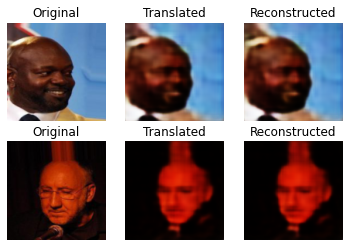

In [13]:
rows, cols = 2, 3

imgs, attrs = gan.dl.load_data('train_filter', batch_size=2, is_testing=True)

new_attrs = create_random_attrs(attrs)

encodings = gan.enc.predict(imgs)

reconstrs = gan.dec.predict([encodings, attrs])

new_imgs = gan.dec.predict([encodings, new_attrs])
# combined.predict([imgs, attrs, new_attrs]) 

gen_imgs = np.array([imgs[0], new_imgs[0], reconstrs[0], imgs[1], new_imgs[1], reconstrs[1]])

gen_imgs = 0.5 * gen_imgs + 0.5

titles = ['Original', 'Translated', 'Reconstructed']
fig, axes = plt.subplots(rows, cols)

count = 0

for i in range(rows):
  for j in range(cols):
    axes[i, j].imshow(gen_imgs[count])
    axes[i, j].set_title(titles[j])
    axes[i, j].axis('off')
    count += 1

plt.show()

In [14]:
gan.dc.predict(new_imgs)

[array([[8.700445e-01],
        [6.844654e-05]], dtype=float32),
 array([[0.01637757, 0.00246808, 0.98649895, 0.99394053, 0.0066309 ,
         0.22844476, 0.74413025, 0.00672266, 0.00412133, 0.00796506],
        [0.12646261, 0.00299805, 0.91827536, 0.99913466, 0.9999953 ,
         0.0088425 , 0.90458155, 0.99566096, 0.00311009, 0.99133563]],
       dtype=float32)]

In [24]:
img_paths = glob('/content/celeba-dataset/train_filter/*')
img_paths.sort()
img_paths = img_paths[25:]

og_imgs = []
for path in img_paths:
  img = gan.dl.imread(path)
  img = scipy.misc.imresize(img, (128, 128, 3))
  og_imgs.append(img)

imgs = np.array(og_imgs)/127.5 - 1.
attrs = np.ones((len(imgs), gan.dl.num_attrs))
# new_attrs = create_random_attrs(attrs)
new_attrs = np.zeros(attrs.shape)
new_attrs[:, 2] = 1

encodings = gan.enc.predict(imgs)

reconstrs = gan.dec.predict([encodings, attrs])
reconstrs = (reconstrs + 1) * 127.5

new_imgs = gan.dec.predict([encodings, new_attrs])
new_imgs = (new_imgs + 1) * 127.5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [29]:
out = gan.dc.predict(new_imgs)

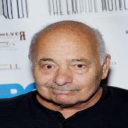

In [40]:
Image.fromarray(((imgs[0] + 1) * 127.5).astype(np.uint8))

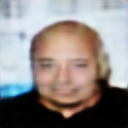

In [38]:
Image.fromarray(new_imgs[0].astype(np.uint8))

In [41]:
out[1]

array([[1.49562955e-03, 1.16169453e-03, 9.99135971e-01, 5.13225794e-04,
        1.10882223e-02, 4.21673059e-04, 2.27593809e-01, 6.16550446e-04,
        1.85943842e-02, 4.89467382e-03],
       [5.87344170e-04, 3.30746174e-04, 9.96554196e-01, 2.04863250e-02,
        1.05905533e-03, 1.70469284e-04, 7.17183650e-02, 8.10107589e-03,
        2.38698721e-03, 1.31636858e-03],
       [5.58560491e-02, 1.21732354e-02, 9.75441217e-01, 1.77115202e-04,
        8.02337229e-02, 3.07375193e-03, 2.98547149e-02, 2.83321440e-02,
        4.33474779e-04, 8.37165499e-05],
       [6.90162182e-03, 7.35044479e-04, 9.79857206e-01, 1.09487772e-03,
        1.69224739e-02, 4.99057770e-03, 3.28369141e-02, 2.51761079e-03,
        1.71030730e-01, 1.43080950e-04],
       [4.90058362e-02, 9.55998898e-04, 9.97689128e-01, 1.45354807e-01,
        1.93744898e-04, 3.33428383e-04, 9.14825797e-02, 9.23725963e-03,
        2.66253948e-03, 3.21987450e-01],
       [3.79443169e-04, 3.11763961e-06, 4.33520883e-01, 1.54955119e-01,
   